# Music
<img src="Music/Y4_Large_reduc.jpg" align="right" width="64" height="64" />

Zen's Music Playround

# Introduction

This page contains some experiments with Jupyter and playing with my music collection. To play happily, we have divided this page into multiple sections.

These sections are:
* [Setup](#Setup "Load the Music Library class and variables")
* [Get random album and cover](#Random-Album "Get a random album and it's track listing.")
* [Get the MPRIS2 player](#Get-the-MRIS2-Player "Get access to the current MRIS2 Player")
* [Library Analysis](#Library-Analysis)
* [SVG Demo](#SVG-Demo)

For useful help, you can check out:
* The [Jupyter Widget List](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)


## Setup

Execute the cell below to instantiate the MusicLib class and make it available as *lib*.

In [2]:
from os import listdir
from os.path import join, isdir, exists, basename
from random import sample
from glob import glob
import ipywidgets as widgets
from IPython.core.display import HTML, display
from textwrap import dedent
import codecs

class Templates(object):
    """
    This class defines varios HTML templates as constants from output in
    the MusicLib class.
    """
    @staticmethod
    def get_album():
        """
        Return the HTML for an album template. The template has placeholders
        for 'artist', 'album' and 'tracks'.
        """
        return dedent('''
            <table>
                <tr>
                  <th><b>{artist}</b></th>
                  <th><b>{album}</b></th>
                </tr>
                <tr>
                  <td>{cover}</td>
                  <td>{tracks}</td>
                </tr>            
            </table>
        ''')
    
    @staticmethod
    def get_image():
        """
        Return the HTML for the album cover with a placeholder for
        'base64'
        """
        return '<img alt="Image" src="data:image/png;base64,{base64}"'\
            ' width="300px" height="300px" />'
    
class MusicLib(object):
    """
    Class for fetching information about our music library, as an experiment
    in jupyter
    """

    def __init__(self, path):
        self.path = path 
    
    def artists(self):
        """ Return a list of lartists. """
        return [name for name in listdir(self.path) if isdir(join(self.path, name))]

    def get_random_artists(self, number):
        """ Return a random list of *number* artists. """
        artists = self.artists()
        return sample(artists, number)

    def get_random_albums(self, artist, number):
        """ Return a random list of *number* albums by *artist*. """
        albums = self.albums(artist)
        if albums:
            return sample(albums, number)
        else:
            raise(Exception("No albums found for {0}".format(artist)))

    def albums(self, artist):
        """ Return a list of albums for the *artist*. """
        path = join(self.path, artist)
        return [name for name in listdir(path) if isdir(join(path, name))]
    
    @staticmethod
    def get_inline_image(file_name):
        """ Return an HTML formatted inline image """
        if file_name == "":
            file_name = "Music/audio_icon.png"
        
        with open(file_name, "rb") as f:
            b64 = codecs.encode(f.read(), 'base64')
            html = Templates.get_image()
            try:
                return html.format(**{'base64': str(b64, 'ascii')})
            except:  
                return html.format(**{'base64': str(b64).encode('ascii')})
            
    
    def get_album_cover(self, artist, album, size=300):
        """
        Return the album cover for the specified album or null string
        if it does not exist.
        """
        path = join(self.path, artist, album)
        pattern = "cover.*"
        matches = glob(join(path, pattern))
        return matches[0] if matches else ""

    def get_album_path(self, artist, album):
        """ Return the full path to the specified album. """
        return join(self.path, artist, album)
            
    @staticmethod
    def _get_any_matches(path, *exts):
        """ Return the first valid files matching the extentions
        in the path specified."""
        for ext in exts:
            matches = glob(join(path, ext))
            if matches:
                return matches
        return None

    def get_album_tracks(self, artist, album):
        """
        Return a list of the album tracks
        """
        def get_name(fname):
            """"Return the nice, cleaned name of the track"""
            return basename(fname)  # [:-4]
        
        path = join(self.path, artist, album)
        matches = self._get_any_matches(
            path, "*.mp3", "*.ogg", "*.m4a", "*.wma")
        if matches:
            return sorted([get_name(f) for f in matches])
        else:
            return []

    def get_album_summary(self, artist, album):
        """ Return a pretty album summary """
        cover = self.get_album_cover(artist, album)
        items = [widgets.Label("{0}: {1}".format(artist, album))]
        [items.append(widgets.Label(track, width=200)) for track in self.get_album_tracks(artist,
                                                                album)]
        right = widgets.VBox(items, width=300)
        return widgets.HBox([cover, right])

    def get_album_summary_html(self, artist, album, out):
        """ Return a pretty album summary """
        with out:
            data = {'artist': artist,
                    'album': album}
            cover = self.get_album_cover(artist, album)       
            tracks = [track for track in self.get_album_tracks(artist, album)]
            data['tracks'] = "<br/>".join(tracks)
            data['cover'] = cover
            html = HTML(Templates.get_album().format(**data))
            display(html)
            

library = "/home/fruitbat/Zen/Music/"
lib = MusicLib(library)           

[Back to top](#Introduction "Back the top of the page")

## Random Album

In [3]:
from IPython.display import clear_output
from ipywidgets import Output
from os import system

class Player(object):
    """
    Control audiacious and volume settings.
    https://wiki.archlinux.org/index.php/PulseAudio#Keyboard_volume_control
    """
    @staticmethod
    def play_pause():
        system('audacious -t')
        
    @staticmethod
    def volume_up():
        system('pactl set-sink-volume 1 +5%')
        
    @staticmethod
    def volume_down():
        system('pactl set-sink-volume 1 -5%')

    @staticmethod
    def enqueue(album):
        """ Add the specified folder to the audacious queue. """
        system('audacious -e "{0}"'.format(album))

    @staticmethod
    def open_folder(album):
        """ Open and play the files in the folder specified . """
        system('audacious -E "{0}"'.format(album))

        
class RandomAlbum(object):
    """ Convenience class for genration a random album dislay"""
    out = None
    artist = None
    album = None

    @staticmethod
    def get():
        """ Generate and display a random album. """
        ra = RandomAlbum
        if ra.out is not None:
            ra.out.clear_output(wait=True)
        else:
            ra.out = Output()
            display(ra.out)

        ra.artist =  lib.get_random_artists(1)[0]
        ra.album =  lib.get_random_albums(ra.artist, 1)[0]
        lib.get_album_summary_html(
            ra.artist, ra.album, ra.out)

    @staticmethod
    def enqueue():
        """ Add the currently displayed album to the audacious
        queue. """
        album = lib.get_album_path(RandomAlbum.artist,
                                   RandomAlbum.album)
        Player.enqueue(album)

    @staticmethod
    def open_folder():
        """ Play the currently displayed album. """
        album = lib.get_album_path(RandomAlbum.artist,
                                   RandomAlbum.album)
        Player.open_folder(album)
    
    
class AlbumButtons():
    """ A simple factory class for proving the buttons"""        
    @staticmethod
    def get():
        def create_button(descrip, func):
            """ Create a button with the specified description and
            fire on func on the click event """
            but = widgets.Button(description=descrip)
            but.on_click(func)
            return but            
        
        btn_dis = create_button('Display a random album',
            lambda dt: RandomAlbum.get())

        btn_enqueue = create_button('Enqueue album',
            lambda dt: RandomAlbum.enqueue())

        btn_open = create_button('Play album',
            lambda dt: RandomAlbum.open_folder())

        return [btn_dis, btn_enqueue, btn_open]

widgets.HBox(AlbumButtons.get())

[Back to top](#Introduction "Back the top of the page")

## Get the MRIS2 Player

In [6]:
from mpris2 import get_players_uri
from mpris2 import Player
try:
    from urllib.parse import urlparse, unquote
except ImportError:
     from urlparse import urlparse

uri = next(get_players_uri())
mp2_player = Player(dbus_interface_info={'dbus_uri': uri})

class MP2():
    """ A simple factory class for proving the buttons"""        
    out = None

    @staticmethod
    def _get_cover(url):
        """ Return the path to the cover art """
        parsed = urlparse(url)
        if parsed.scheme == 'file':
            return unquote(parsed.path)
        else:
            return "Music/audio_icon.png"
        
    @staticmethod
    def show_info():
        mp = MP2
        if mp.out is not None:
            mp.out.clear_output(wait=True)
        else:
            mp.out = Output()
            display(mp.out)

        with mp.out:
            # 'xesam:title - Turn Down for What (Dj KreCer & DJ Alex Shafrygin remix)'
            # "xesam:artist - dbus.Array([dbus.String('DJ Snake & Lil Jon')], signature=dbus.Signature('s'), variant_level=1)"
            # 'xesam:album - Various'
            # 'xesam:url - file:///home/fruitbat/Zen/Music/DJ%20Snake/Various/DJ%20Snake%20%26%20Lil%20Jon%20-%20Turn%20Down%20for%20What%20%28Dj%20KreCer%20%26%20DJ%20Alex%20Shafrygin%20remix%29.mp3'
            # 'mpris:length - 237860000'
            # 'mpris:artUrl - file:///home/fruitbat/Zen/Music/DJ%20Snake/Various/cover.jpg'
            # 'mpris:trackid - /org/mpris/MediaPlayer2/CurrentTrack'
            data = mp2_player.Metadata
            fname = MP2._get_cover(str(data['mpris:artUrl']))

            html = Templates.get_album().format(**{
                "artist": data['xesam:artist'][0],
                "album": data['xesam:album'],
                "cover": MusicLib.get_inline_image(fname),
                "tracks": data['xesam:title']})
            display(HTML(html))
                

    @staticmethod
    def get_buttons():
        def change_volume(val):
            mp2_player.Volume += val
        
                
        def create_button(descrip, func):
            """ Create a button with the specified description and
            fire on func on the click event """
            but = widgets.Button(description=descrip)
            but.on_click(func)
            return but            
        
        btn_prev = create_button('Previous',
            lambda dt: mp2_player.Previous())

        btn_pp = create_button('Play/Pause',
            lambda dt: mp2_player.PlayPause())

        btn_next = create_button('Next',
            lambda dt: mp2_player.Next())

        btn_vol_up = create_button('Volume up',
            lambda dt: change_volume(0.05))
        
        btn_vol_down = create_button('Volume down',
            lambda dt: change_volume(-0.05))
        
        btn_info = create_button("Show player info",
            lambda dt: MP2.show_info())
        return [btn_prev, btn_pp, btn_next, btn_vol_up, btn_vol_down, btn_info]
    
widgets.HBox(MP2.get_buttons())

[Back to top](#Introduction "Back the top of the page")

## Library Analysis

In [61]:
# Print missing tracks
for artist in lib.artists():
    for album in lib.albums(artist):
        cover = lib.get_album_cover(artist, album) 
        if cover == "" and 'Various' not in artist:
            print("Missing cover for {0} - {1}".format(artist, album))
        

Missing cover for Sebada Sebada - Kgwedi
Missing cover for Deep Dish - Westside
Missing cover for Vatos Locos - Unknown
Missing cover for Classical - Ludwig Van Beethoven
Missing cover for Classical - Joseph Haydn
Missing cover for Classical - Wolfgang Amadeus Mozart
Missing cover for Classical - Johannes Brahms


## SVG Demo

The cell below demonstrates the inline SVG ability of the notebook...

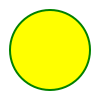

In [15]:
from IPython.display import SVG
SVG(data='''
<svg width="100" height="100">
  <circle cx="50" cy="50" r="40" stroke="green" stroke-width="2" fill="yellow" />
</svg>
''')


[Back to top](#Introduction "Back the top of the page")